In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import re

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor


from secondary_functions.charts import plot_bars
import yaml

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

SEED = 1618
warnings.filterwarnings('ignore')
pd.options.display.max_columns = 50
pd.set_option('display.float_format', '{:.3f}'.format)

In [2]:
with open('preprocessing.yml', 'r', encoding='utf-8') as file:
    config = yaml.load(file, Loader=yaml.FullLoader)
config

{'change_type_columns': {'Рейтинг': 'float32',
  'Мощность_двигателя_лс': 'int16',
  'Пробег_км': 'int32',
  'Год_выпуска': 'int16',
  'Цена': 'int32',
  'Объём_двигателя_л': 'float32',
  'Обмен': 'int8',
  'Много_владельцев': 'int8',
  'Срок_эксплуатации': 'int8',
  'История_пробега_кол_во_записей': 'int8',
  'Владельцев_по_ПТС': 'int8',
  'Выпуск_кол_во_лет': 'int8'},
 'columns_to_drop': ['Название_авто',
  'Расположение',
  'Наименование_поколения'],
 'catb_params': {'boosting_type': 'Ordered',
  'bootstrap_type': 'Bernoulli',
  'cat_features': ['Поколение',
   'Состояние',
   'Модификация',
   'Тип_двигателя',
   'Коробка_передач',
   'Привод',
   'Комплектация',
   'Тип_кузова',
   'Цвет',
   'Руль',
   'Управление_климатом',
   'ПТС',
   'Бренд_авто',
   'Модель_авто',
   'Город',
   'Федеральный_округ',
   'Степень_износа'],
  'colsample_bylevel': 0.07016296475032051,
  'depth': 12,
  'eval_metric': 'MAE',
  'iterations': 3000,
  'l2_leaf_reg': 12.236324946000956,
  'learning_ra

# Описание задачи.

Данные получены при помощи парсинга сайта avito.ru. Необходимо создать модель, способную по характеристикам автомобиля и дополнительным параметрам предсказать его цену. 

**Данные по автомобилям:**

Целевая переменная - Цена.

- Рейтинг - рейтинг автомобиля на сайте.
- Год выпуска - год производства автомобиля.
- Поколение - поколение автомобиля.
- Пробег, км - сколько проехал автомобиль в километрах.
- История пробега, кол-во записей - количество записей об истории пробега в автотеке. 
- Владельцев по ПТС - количество владельцев, записанных в ПТС.
- Состояние - общее состояние автомобиля.
- Модификация - модификация автомобиля.
- Объём двигателя, л - объём двигателя в литрах.
- Тип двигателя - тип двигателя.
- Коробка передач - тип коробки передач.
- Привод - тип привода.
- Комплектация - комплектация автомобиля
- Тип кузова - тип кузова автомобиля.
- Цвет - цвет автомобиля.
- Руль - расположение руля.
- Управление климатом - тип системы управления климатом
- ПТС - вид ПТС.
- Обмен - рассматривается ли обмен автомобиля на другой, или альтернативные варианты.
- Бренд авто - наименование бренда авто, производитель.
- Модель авто - наименование модели авто.
- Город - город, в котором продаётся авто.
- Регион - регион, в котором продаётся авто.
- Выпуск, кол-во лет - количество лет, в течение которого шёл выпуск автомобиля
- Мощность двигателя, лс - мощность двигателя автомобиля, в лошадиных силах.

In [3]:
df = pd.read_csv('./data_store/parsed_data.csv')

In [4]:
poor_categories = df['Модификация'].value_counts()[
    df['Модификация'].value_counts() < 2].index
poor_categories

Index(['1.8 dCi MT', '2.0 CNG AT', '2.0 Blue dCi MT', '328i 2.0 Steptronic',
       '2.0 dCi 4WD CVT', '728i 2.8 AT', '1.6 CRDi AMT', '335xi 3.0 AT',
       '2.0 dCi AMT', '2.0 D AMT',
       ...
       'A 150 1.5 CVT', 'V 250 d 2.1 4MATIC AT L1', 'E 200d 2.1 5G-Tronic',
       'E63 S 4.0 4MATIC+ SPEEDSHIFT MCT 9G', 'G 350d 3.0 4MATIC 7G-Tronic',
       '516 CDI 2.2 MT', 'S 500 5.5 4MATIC 7G-Tronic',
       'GLE 450d 3.0 4MATIC 9G-Tronic', '200 2.0 AT', '300 3.0 MT'],
      dtype='object', name='Модификация', length=453)

In [5]:
df[:5]

,Название авто,Рейтинг,Цена,Расположение,Год выпуска,Поколение,"Пробег, км","История пробега, кол-во записей",Владельцев по ПТС,Состояние,Модификация,"Объём двигателя, л",Тип двигателя,Коробка передач,Привод,Комплектация,Тип кузова,Цвет,Руль,Управление климатом,ПТС,Обмен,Бренд авто,Модель авто,Город,Федеральный округ,Наименование поколения,"Выпуск, кол-во лет","Мощность двигателя, лс"
0,"Audi Q3 2.0 AMT, 2013, 166 000 км",4.800,1745000,"Самарская обл., Самара, Московское ш., 262А",2013.000,I (2011—2014),166000.000,11.000,3.000,Не битый,2.0 TFSI quattro S tronic,2.000,Бензин,Робот,Полный,Базовая,Внедорожник 5-дверный,Чёрный,Левый,NaN,NaN,NaN,Audi,Q3,Самара,Приволжский,I,3.000,170.000
1,"Audi Q7 3.0 AT, 2021, 29 226 км",5.000,8785500,"Москва, Волоколамское ш., 73",2021.000,4M рестайлинг (2019—2024),29226.000,2.000,1.000,Не битый,45 TDI 3.0 quattro Tiptronic,3.000,Дизель,Автомат,Полный,Sport,Внедорожник 5-дверный,Чёрный,Левый,Климат-контроль многозонный,NaN,NaN,Audi,Q7,Волоколамск,Центральный,4M рестайлинг,5.000,249.000
2,"Audi Q8 3.0 AT, 2022, 100 км",5.000,11200000,"Москва, ул. Верхние Поля, 2",2022.000,I (2018—2023),100.000,3.000,1.000,Не битый,55 TFSI 3.0 quattro Tiptronic,3.000,Бензин,Автомат,Полный,Advance,Внедорожник 5-дверный,Чёрный,Левый,Климат-контроль многозонный,Электронный,Не интересует,Audi,Q8,Москва,Центральный,I,5.000,340.000
3,"Audi Q7 3.0 AT, 2013, 151 488 км",4.800,2099000,"Санкт-Петербург, пр-т Маршала Жукова, 78",2013.000,4L рестайлинг (2009—2015),151488.000,15.000,2.000,Не битый,3.0 TDI quattro Tiptronic,3.000,Дизель,Автомат,Полный,NaN,Внедорожник 5-дверный,Белый,Левый,Климат-контроль многозонный,NaN,Возможен,Audi,Q7,Жуков,Центральный,4L рестайлинг,6.000,245.000
4,"Audi Q8 3.0 AT, 2022, 3 261 км",5.000,10400000,"Москва, Бережковская наб., 38с2",2022.000,I (2018—2023),3261.000,NaN,1.000,Не битый,50 TDI 3.0 quattro Tiptronic,3.000,Дизель,Автомат,Полный,Базовая,Внедорожник 5-дверный,Красный,Левый,NaN,NaN,NaN,Audi,Q8,Москва,Центральный,I,5.000,286.000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37568 entries, 0 to 37567
Data columns (total 29 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Название авто                    37568 non-null  object 
 1   Рейтинг                          36861 non-null  float64
 2   Цена                             37568 non-null  int64  
 3   Расположение                     37568 non-null  object 
 4   Год выпуска                      37568 non-null  float64
 5   Поколение                        37568 non-null  object 
 6   Пробег, км                       33530 non-null  float64
 7   История пробега, кол-во записей  31357 non-null  float64
 8   Владельцев по ПТС                33530 non-null  float64
 9   Состояние                        37568 non-null  object 
 10  Модификация                      37524 non-null  object 
 11  Объём двигателя, л               37442 non-null  float64
 12  Тип двигателя     

In [7]:
df.describe()

,Рейтинг,Цена,Год выпуска,"Пробег, км","История пробега, кол-во записей",Владельцев по ПТС,"Объём двигателя, л","Выпуск, кол-во лет","Мощность двигателя, лс"
count,36861.000,37568.000,37568.000,33530.000,31357.000,33530.000,37442.000,37567.000,37524.000
mean,4.667,1850525.846,2012.975,164820.119,9.979,2.445,10.874,5.054,157.934
std,0.240,2405473.453,7.563,100777.928,7.753,1.162,1714.750,3.311,71.743
min,2.600,1000.000,1934.000,1.000,0.000,1.000,0.600,1.000,33.000
25%,4.600,640000.000,2008.000,93827.500,5.000,1.000,1.600,3.000,109.000
50%,4.700,1239000.000,2013.000,160000.000,9.000,2.000,1.800,4.000,143.000
75%,4.800,2299000.000,2019.000,221000.000,13.000,4.000,2.200,6.000,186.000
max,5.000,48000000.000,2024.000,1000000.000,99.000,4.000,331805.000,42.000,802.000


In [8]:
df.describe(include='object')

,Название авто,Расположение,Поколение,Состояние,Модификация,Тип двигателя,Коробка передач,Привод,Комплектация,Тип кузова,Цвет,Руль,Управление климатом,ПТС,Обмен,Бренд авто,Модель авто,Город,Федеральный округ,Наименование поколения
count,37568,37568,37568,37568,37524,37568,37568,37568,30290,37457,37568,37568,20889,26996,30753,37568,37568,36167,36167,37567
unique,31516,20421,1479,2,1503,5,4,3,904,13,17,2,11,3,2,28,896,653,8,586
top,"EXEED RX 2.0 AMT, 2023 Новый","Санкт-Петербург, ул. Дыбенко, 26",I (2022—2024),Не битый,1.6 MT,Бензин,Автомат,Передний,Базовая,Внедорожник 5-дверный,Белый,Левый,Климат-контроль многозонный,Оригинал,Не интересует,Renault,Focus,Москва,Центральный,I
freq,192,139,767,37061,4447,32414,16107,22550,10771,14764,9185,36337,10791,18133,21468,1742,815,4239,12719,10735


Выводы:

- Достаточно много категориальных признаков, а также пропусков в данных.
- Подавляющее большинство автомобилей в выборке с бензиновым типом двигателя.
- Большинство авто леворульные, что характерно для России.
- В среднем возраст продаваемых авто 10 лет, но есть авто с годом выпуска 1949, что очень похоже на выброс.
- В среднем каждая модель определённого поколения выпускается около 5 лет, есть авто с длиной выпуска модели 42 года, что тоже очень похоже на выброс.
- Признак владельцев по ПТС нужно будет разбить на бины, т. к. при первичной очистке мы заменяли строковое значение "4+", которое подразумевает больше 4, на целочисленное 4. Как раз напрашиваются 2 бина: много - мало, больше 4 и меньше 4.
- Почти все авто продаются в "не битом" состоянии. Большая часть в Центральном регионе России.
- Есть авто с 1 км пробега, что тоже похоже на выброс. В среднем все представленные авто ездят около 160 тыс. км. У авито есть архив по пробегу называемый автотека, присутствует авто с более чем 99 записями - скорее всего тоже выброс.
- Интересно, что большинство и не заинтересованы в обмене авто, а только в его продажи, достаточно много людей готовы рассмотреть обмен как альтернативу.

# Гипотезы.

Посмотрим на общее количество автомобилей по брендам, а также на числовые признаки поближе.

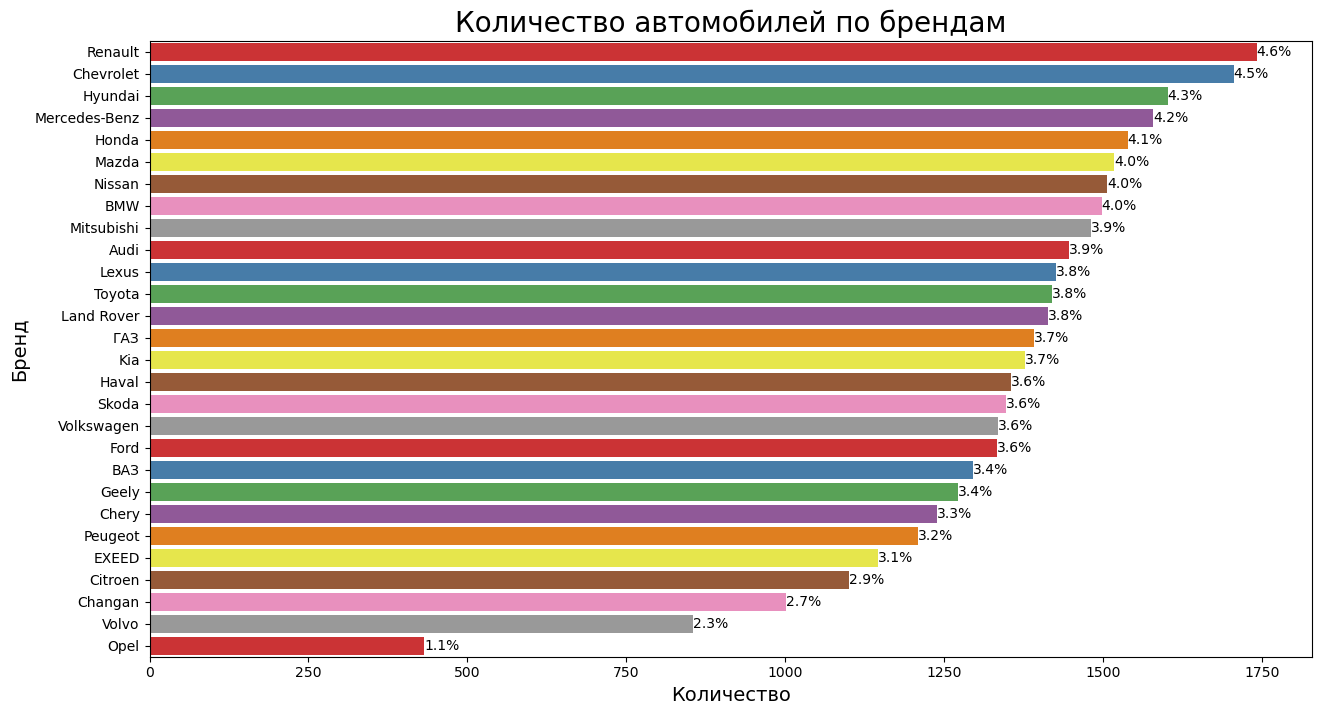

In [9]:
plt.figure(figsize=(15, 8))

ax = sns.countplot(data=df['Бренд авто'],
                   palette='Set1',
                   order=df['Бренд авто'].value_counts().index)
total = df['Бренд авто'].count()

for container in ax.containers:
    ax.bar_label(container, fmt=lambda x: f'{(x/total)*100:0.1f}%')

plt.title('Количество автомобилей по брендам', fontsize=20)
plt.xlabel('Количество', fontsize=14)
plt.ylabel('Бренд', fontsize=14)
plt.show()

В целом в каждом бренде, кроме Opel, достаточно много автомобилей.

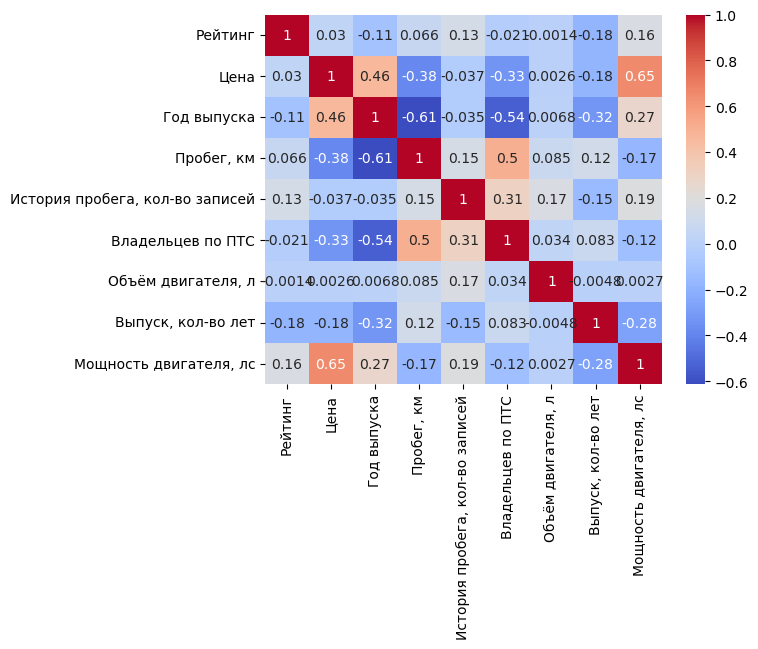

In [10]:
sns.heatmap(df.select_dtypes(exclude='object').corr(),
            cmap='coolwarm',
            annot=True);

Как видим, сильно скореллированных признаков нет. Самая большая корреляция у объёма и мощности двигателя, это и логично, больше литров = больше лошадей. Но самое интересное, что наша целевая переменная Цена коррелирует больше всего с мощностью и годом выпуска, и только потом уже объём двигателя, а так же, чем больше в ПТС владельцев, тем хуже это будет сказываться на Цене - достаточно выраженная обратная корреляция. Также наблюдается выраженная обратная корреляция у года выпуска и пробега - чем больше пробег, тем меньше год выпуска.

## Гипотеза 1.

- Есть бренды, которые продаются дороже относительно других. Поэтому стоит рассматривать определённый бренд авто в зависимости от дохода покупателя.

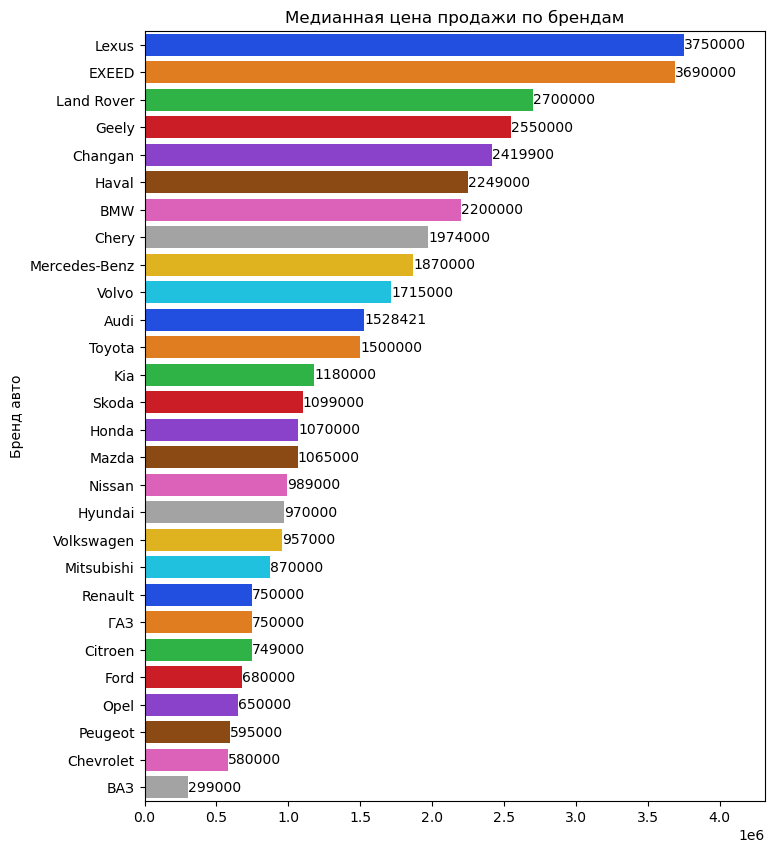

In [11]:
fig, ax = plt.subplots(figsize=(8, 10))

sns.barplot(x=df.groupby('Бренд авто')['Цена'].median().values,
            y=df.groupby('Бренд авто')['Цена'].median().index,
            order=df.groupby('Бренд авто')['Цена'].median().sort_values(
                ascending=False).index,
            palette='bright',
            ax=ax)
for cont in ax.containers:
    ax.bar_label(cont, fmt=lambda x: f'{x:.0f}')
ax.margins(x=0.15)
plt.title('Медианная цена продажи по брендам');

Так как брендов много, поделим их на 4 части: азиаты, европейцы, русские и американцы.

In [12]:
asian_brands = [
    'Lexus', 'Toyota', 'Honda', 'Mazda', 'Nissan', 'Mitsubishi', 'EXEED',
    'Geely', 'Changan', 'Haval', 'Chery', 'Kia', 'Hyundai'
]
eu_brands = [
    'Land Rover', 'BMW', 'Mercedes-Benz', 'Audi', 'Volkswagen', 'Opel',
    'Volvo', 'Skoda', 'Renault', 'Citroen', 'Peugeot'
]
russian_brands = ['ГАЗ', 'ВАЗ']
usa_brands = ['Ford', 'Chevrolet']

In [13]:
asian_part = df.loc[df['Бренд авто'].isin(asian_brands)]
eu_part = df.loc[df['Бренд авто'].isin(eu_brands)]
russian_part = df.loc[df['Бренд авто'].isin(russian_brands)]
usa_part = df.loc[df['Бренд авто'].isin(usa_brands)]
part_dict = {'Азия': np.linspace(0, 40000000, 15),
             'Европа': np.linspace(0, 50000000, 15),
             'Россия': np.linspace(0, 6000000, 15),
             'США': np.linspace(0, 12000000, 15)}

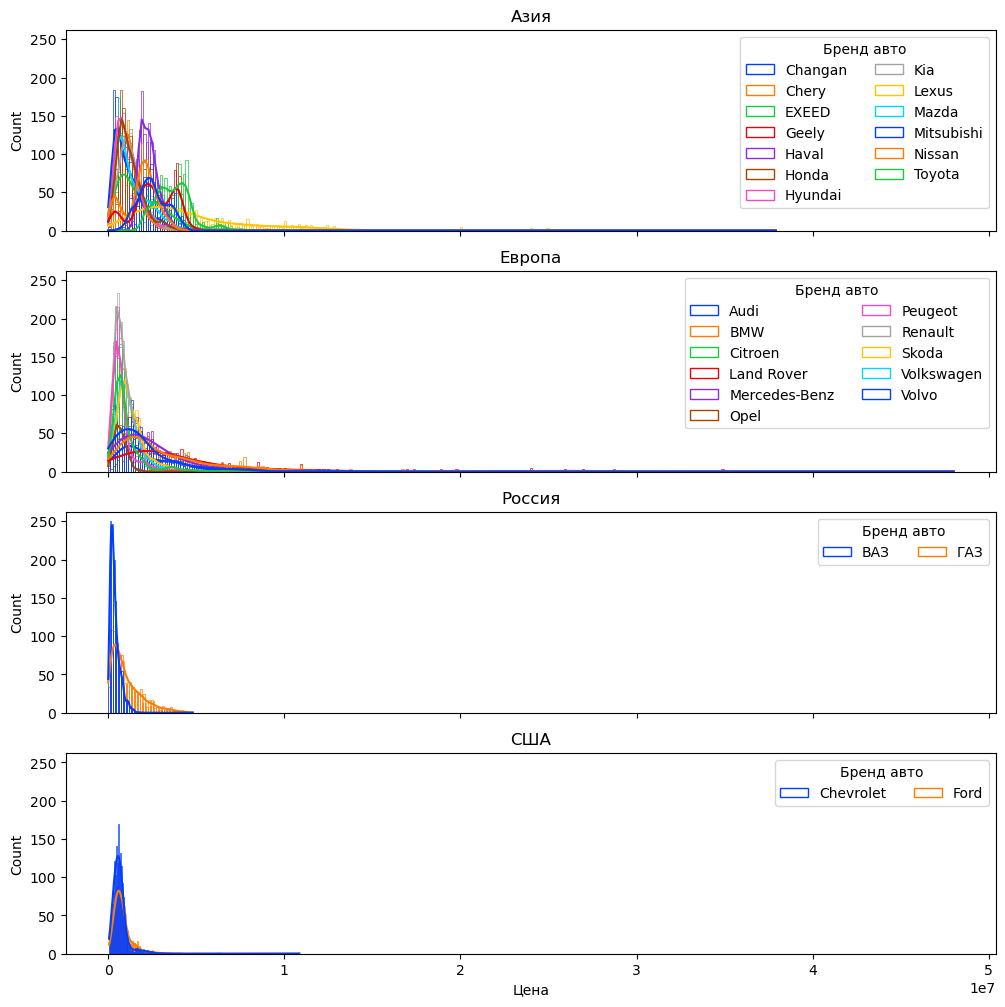

In [14]:
fig, axes = plt.subplots(4, 1, figsize=(12, 12), sharex=True, sharey=True)
for ax, data_part, name in zip(axes.flat,
                               (asian_part, eu_part, russian_part, usa_part),
                               part_dict.keys()):
    sns.histplot(data=data_part,
                 x='Цена',
                 hue='Бренд авто',
                 fill=False,
                 kde=True,
                 palette='bright',
                 ax=ax)
    sns.move_legend(ax, "upper right", ncols=2)
    ax.set_title(name)

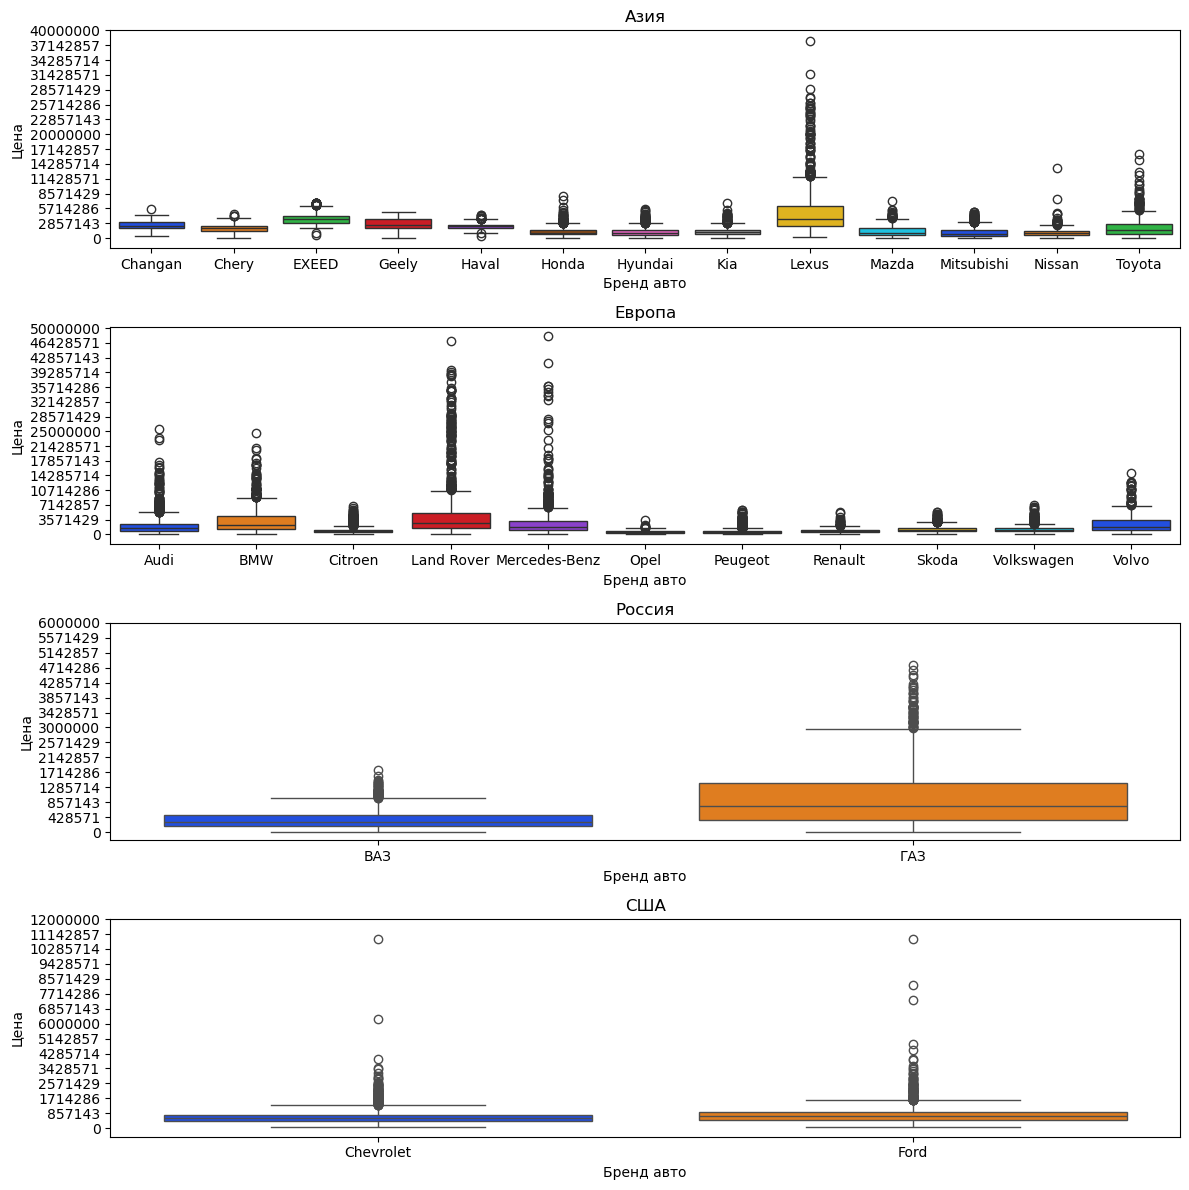

In [15]:
fig, axes = plt.subplots(4, 1, figsize=(12, 12))

for ax, data_part, name in zip(axes.flat,
                               (asian_part, eu_part, russian_part, usa_part),
                               part_dict.keys()):
    sns.boxplot(data=data_part,
                x='Бренд авто',
                y='Цена',
                hue='Бренд авто',
                palette='bright',
                ax=ax)
    ax.set_title(name)
    ax.ticklabel_format(axis='y', style='plain')
    ax.set_yticks(part_dict[name])
plt.tight_layout();

**Гипотеза подтвердилась.** Стабильно дороже стоят EXCEED и Lexus, хоть они и уступают объёму предложения. Но если брать в рассчёт экстремальные значения, то видим, что есть цены на Audi, BMW, Lexus, Land Rover и Mercedes которые сильно выходят за рамки межквартильного размаха.

Рассмотрим на основании этих же графиков дополнительную гипотезу.
## Гипотеза 1.5

- Азиатские автомобили стоят дороже, чем другие (русские, европейские, американские).

**Гипотеза частично подтвердилась.** Количественно азиаты продаются дороже, чем конкуренты. Но если брать макисмальные цены автомобилей, они уступают своим европейским собратьям. Американцы продаются дороже, чем отечественные.

## Гипотеза 2.

- У любого бренда автомобиля в линейке моделей можно найти все типы коробок передач. Вдруг у потенциального покупателя есть предпочтения, например "хочу только автомат", или "только не робот или вариатор, они часто ломаются, или сбоят".

Посмотрим на доли типов коробок передач в разрезе брендов.

<Axes: title={'center': 'Коробка передач'}, xlabel='Классы', ylabel='Проценты'>

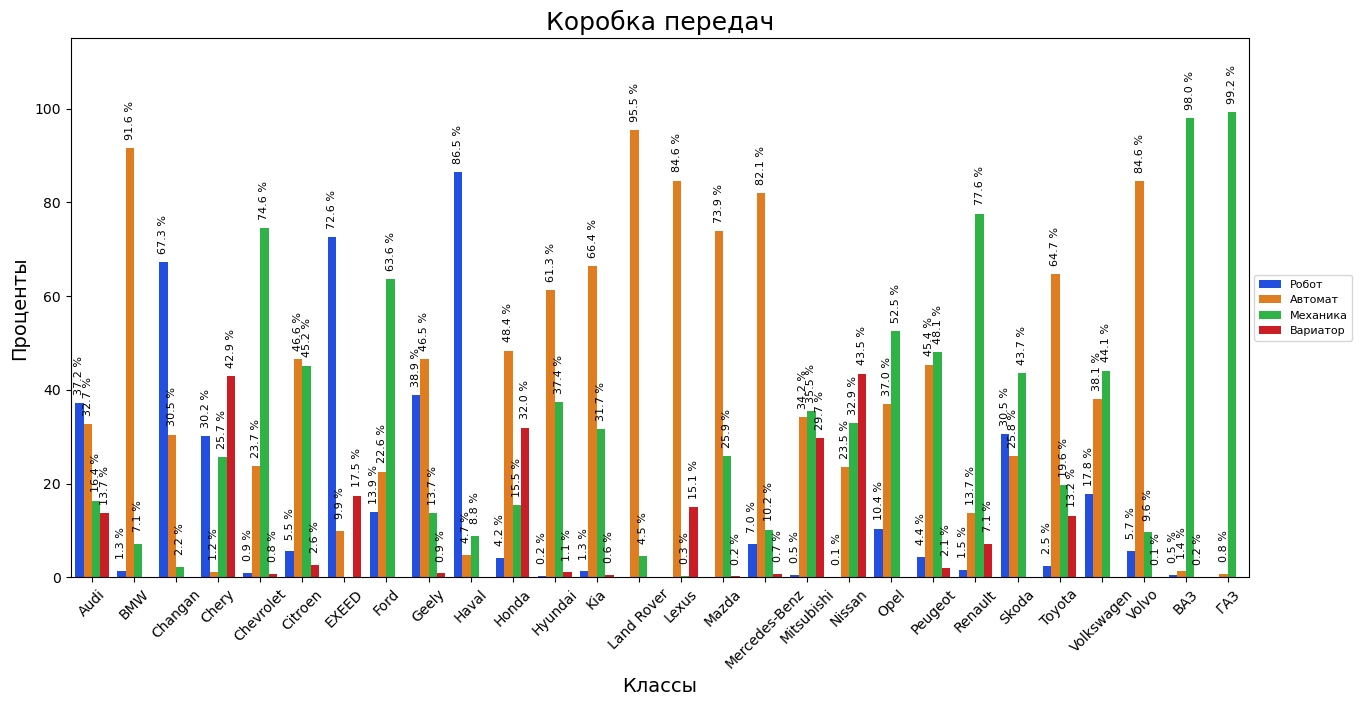

In [16]:
plt.figure(figsize=(19, 7))

plot_bars(df=df, target='Бренд авто', feature='Коробка передач');

**Гипотеза не подтвердилась.** У каждого из брендов преобладает свой тип коробки, например Автомат у Lexus, или Робот у Haval, отечественный автопром так и вовсе почти весь оказался на Механике. У брендов Audi, Chery, Citroen, Geely, Honda, Peugeot, Renault и Toyota есть модели со всеми типами коробок.

## Гипотеза 3.

- Автомобили в любой части России стоят +- одинаково. Нет необходимости ехать далеко за более привлекательной ценой.

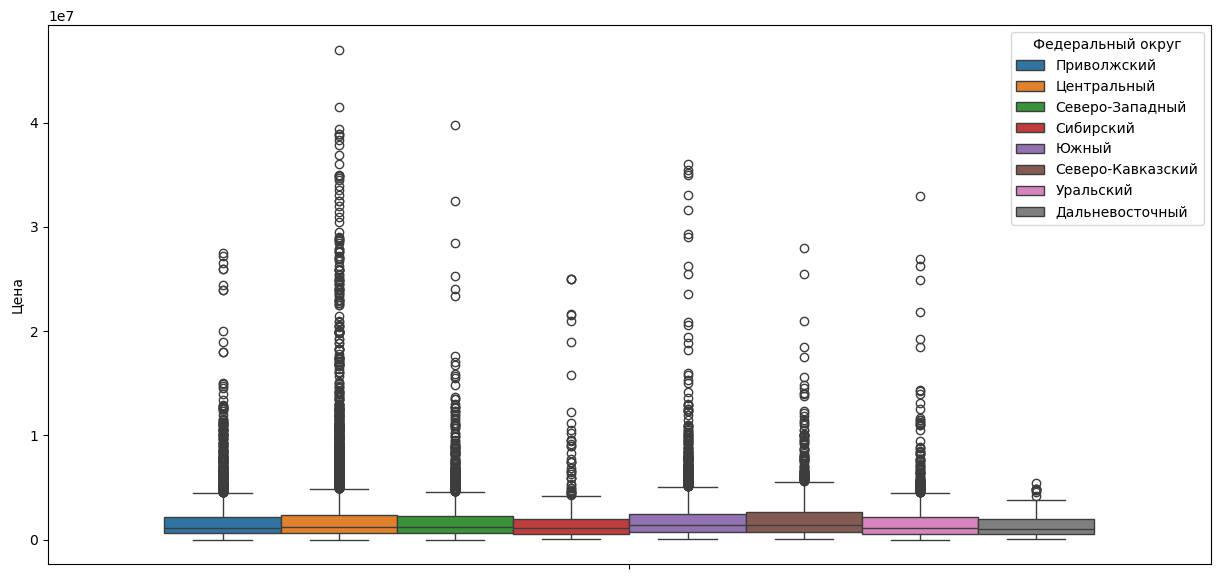

In [17]:
plt.figure(figsize=(15, 7))

sns.boxplot(data=df,
            y='Цена',
            hue='Федеральный округ');

**Гипотеза частично подтвердилась.** Сильных различий между ценами авто в разных ФО в большинстве своём не наблюдается. Но, например, если нам понадобится супердорогой элитный авто, то предпочтительнее ехать за ним в Центральный ФО, а не в Дальневосточный или Сибирский.

## Гипотеза 4.

- В Центральном ФО сосредоточено самое большое количество автомобилей. Если ехать выбирать, то почти все бренды можно найти практически в одном месте.

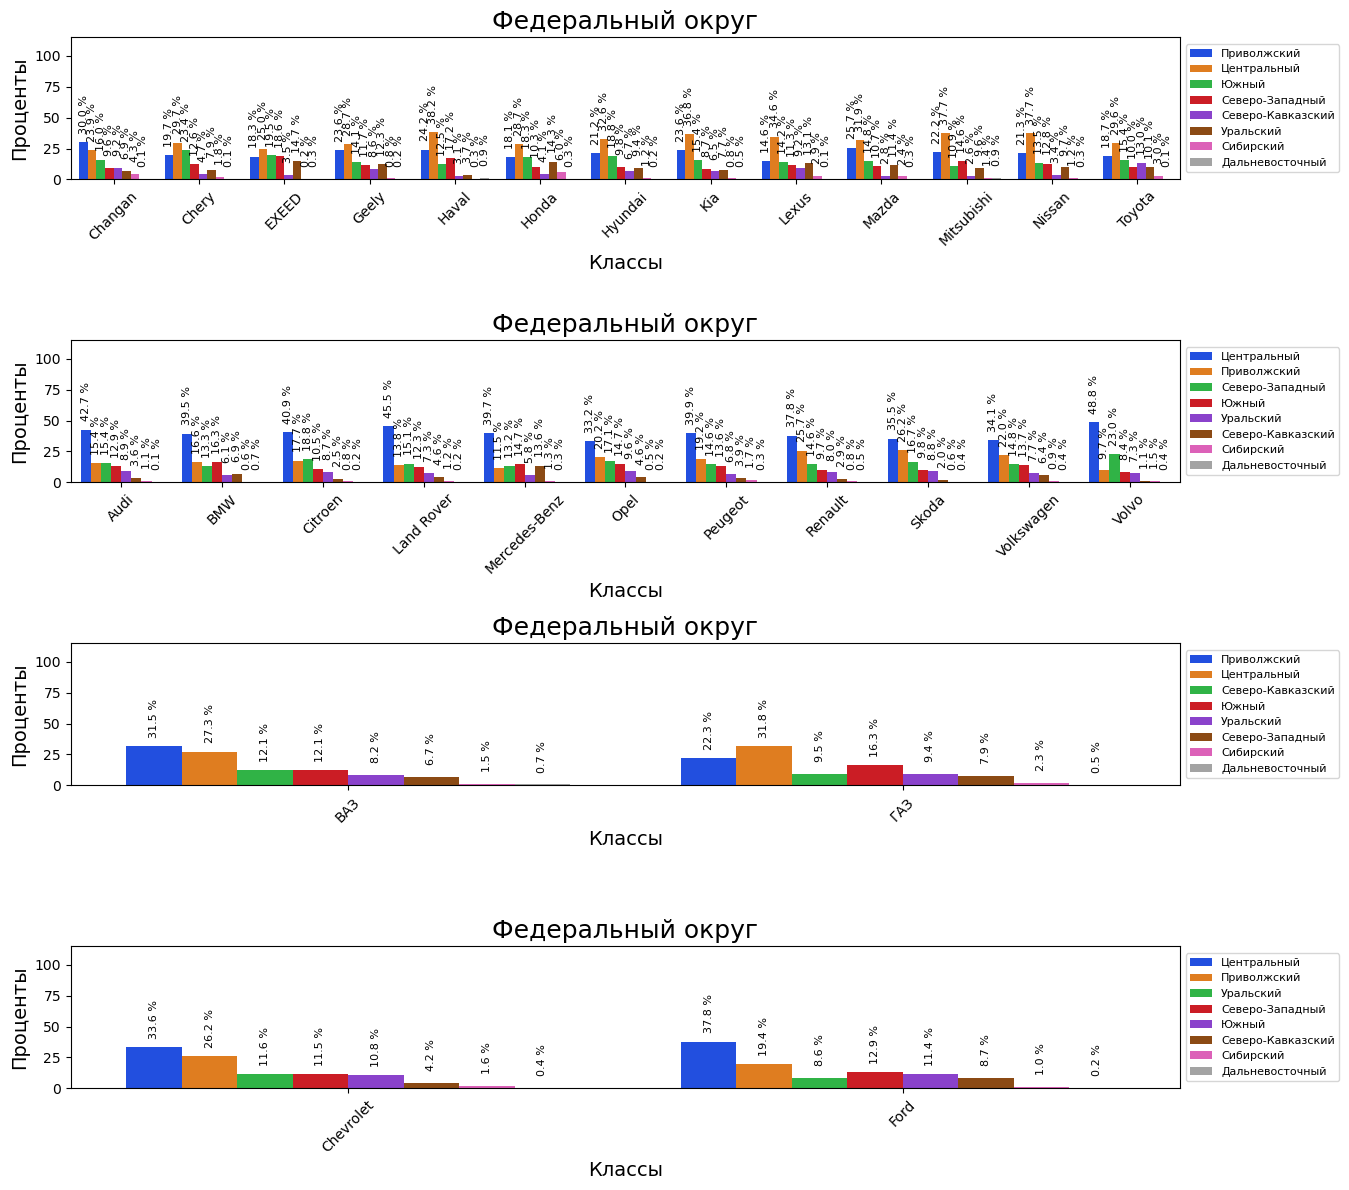

In [70]:
fig, axes = plt.subplots(4, 1, figsize=(12, 12), sharey=True)

for ax, data_part in zip(axes.flat,
                               (asian_part, eu_part, russian_part, usa_part)):
    plot_bars(df=data_part,
              target='Бренд авто',
              feature='Федеральный округ',
              ax=ax)
plt.tight_layout();

**Гипотеза подтвердилась**: самые крупные регионы по количеству автомобилей - это Центральный и Приволжский.

## Гипотеза 5.

- Каждый бренд авто делает упор на какой-то конкретный тип привода. Если мы захотим полноприводный внедорожник, то будем смотреть определённые бренды, а не все подряд.

<Axes: title={'center': 'Привод'}, xlabel='Классы', ylabel='Проценты'>

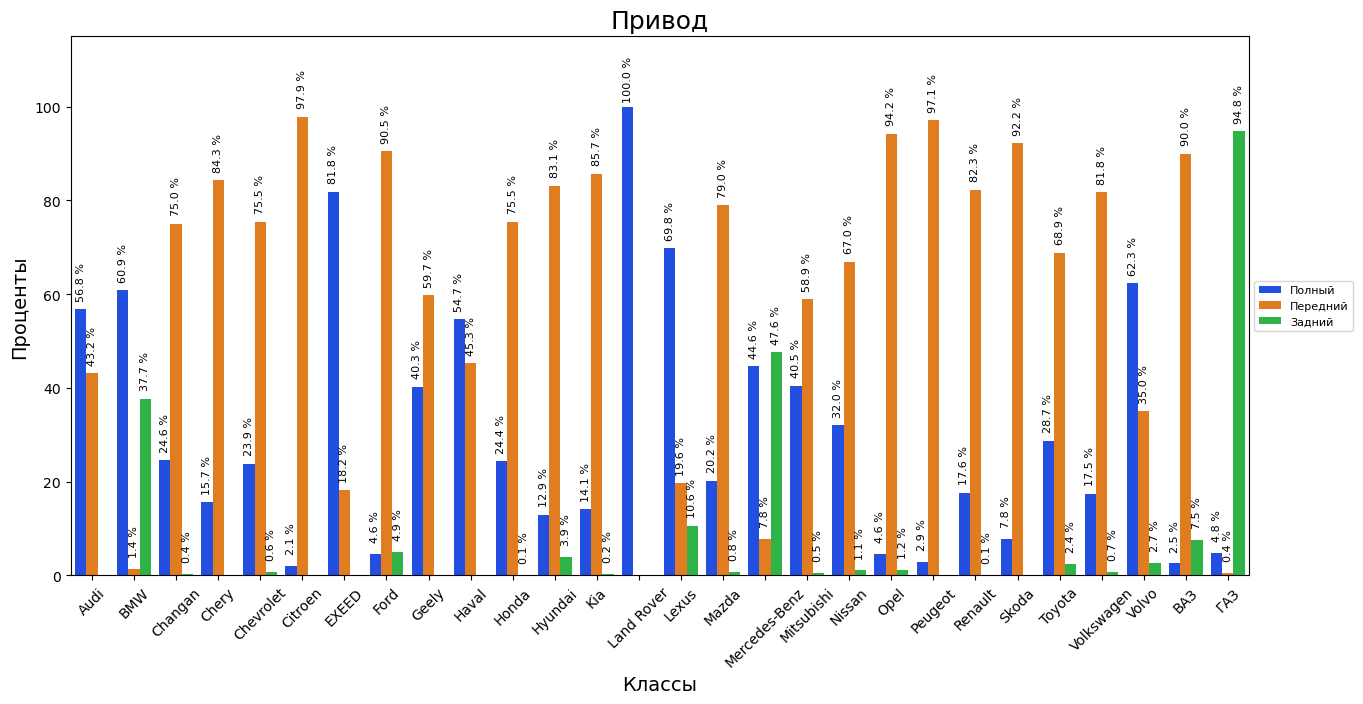

In [19]:
plt.figure(figsize=(19, 7))

plot_bars(df=df, target='Бренд авто', feature='Привод');

**Гипотеза частично подтвердилась.** Бренды сильно различаются по тому, какие типы приводов используются в их линейках авто, но мало кто фокусируется на каком то одном. Land Rover, ГАЗ, Citroen - больше используют какой-то 1 тип. А вот в остальных приводы распределились совершенно по разному.

## Гипотеза 6.

- Автомобили, произведённые до 2007 года дешевле автомобилей, произведённых после.

In [20]:
before_2007 = df.loc[df['Год выпуска'] <= 2007]
after_2007 = df.loc[df['Год выпуска'] > 2007]

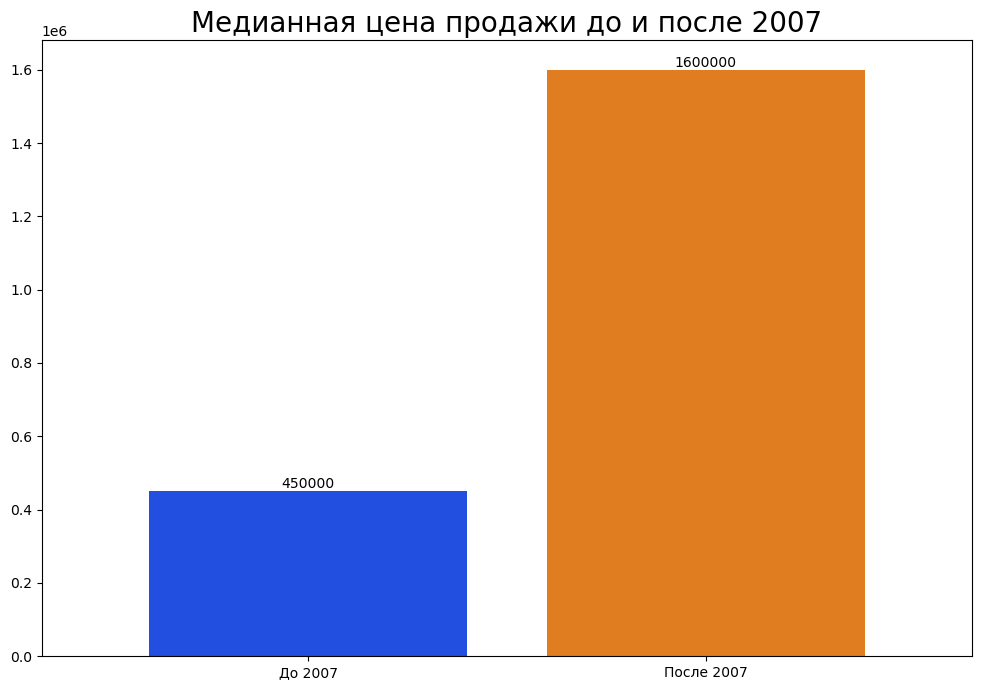

In [21]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.barplot(x=('До 2007', 'После 2007'),
            y=(before_2007['Цена'].median(), after_2007['Цена'].median()),
            palette='bright',
            ax=ax)
for cont in ax.containers:
    ax.bar_label(cont, fmt=lambda x: f'{x:.0f}')
ax.margins(x=0.15)
plt.title('Медианная цена продажи до и после 2007', fontsize=20);

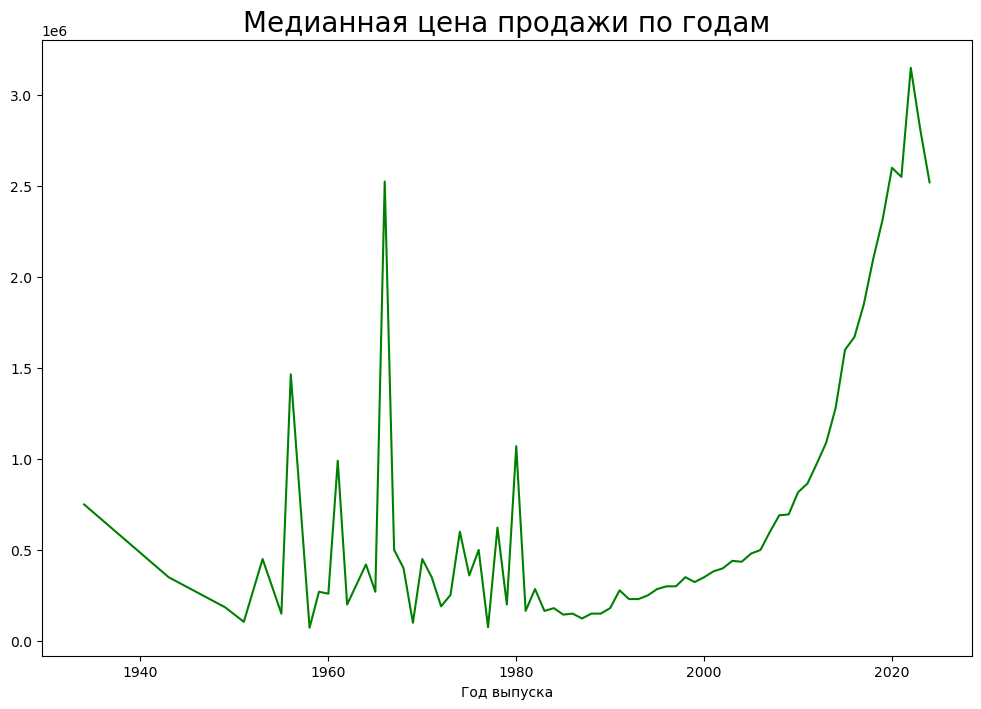

In [22]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.lineplot(x=df.groupby('Год выпуска')['Цена'].median().index,
            y=df.groupby('Год выпуска')['Цена'].median().values,
            color='green',
            ax=ax)
plt.title('Медианная цена продажи по годам', fontsize=20);

**Гипотеза подтвердилась.** Автомобили до 2007 и правда продаются дешевле. Примерно с 1952 цены начали скачкообразно расти и также резко падать, скорее всего это связано с ажиотажем на новые модели или технологии. С 1980 всё стало спокойнее и далее уже цены росли более гладко, хоть в 2020 мы и наблюдаем резкий спад медианной цены.

## Гипотеза 7.

- Самый распростарённый тип автомобиля на рынке - это леворульный седан.

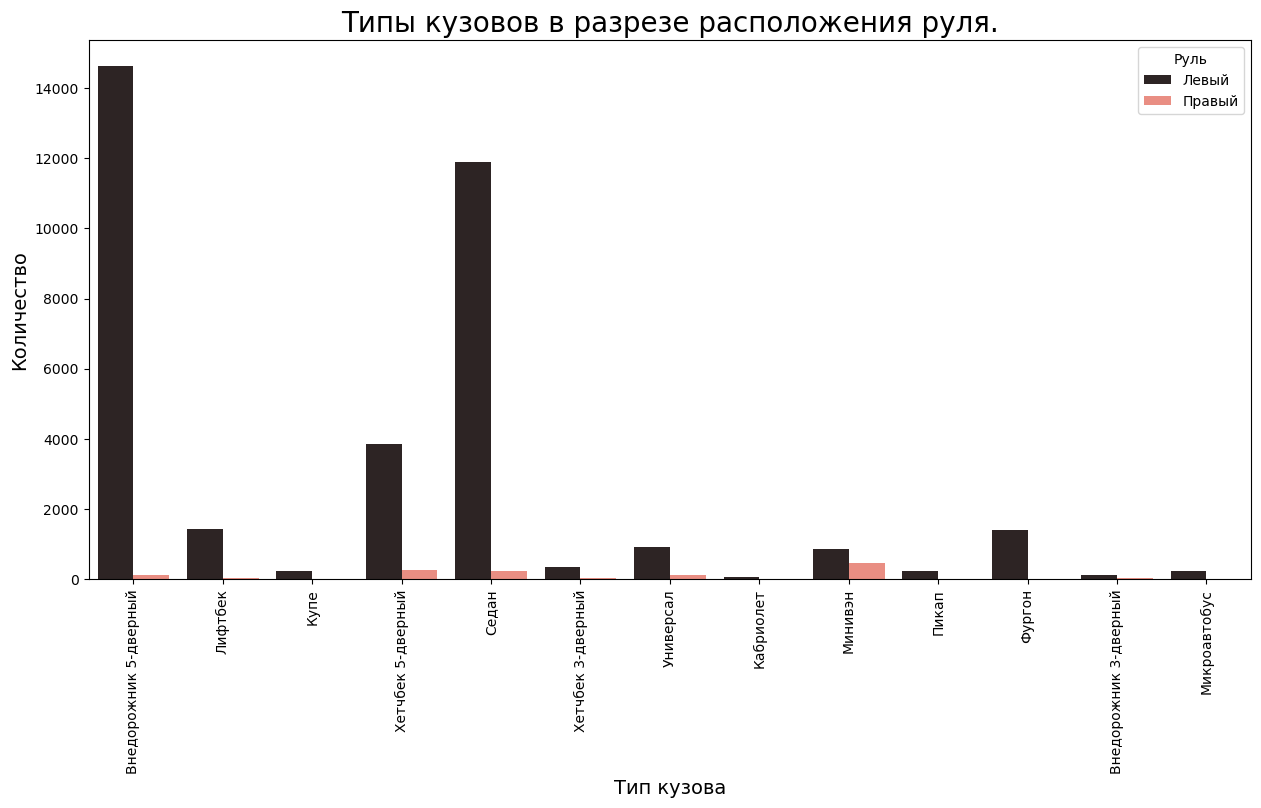

In [23]:
plt.figure(figsize=(15, 7))

sns.countplot(data=df, x='Тип кузова', hue='Руль', color='salmon')
plt.title('Типы кузовов в разрезе расположения руля.', fontsize=20)
plt.xlabel('Тип кузова', fontsize=14)
plt.ylabel('Количество', fontsize=14)
plt.xticks(rotation=90);

**Гипотеза не подтвердилась.** Несмотря на большую распространённость леворульных седанов, на текущий момент больше всего на рынке леворульных 5-дверных внедорожников.

## Гипотеза 8.

- Автомобили старше  13 лет с высокой вероятностью будут иметь 4 или более владельцев.

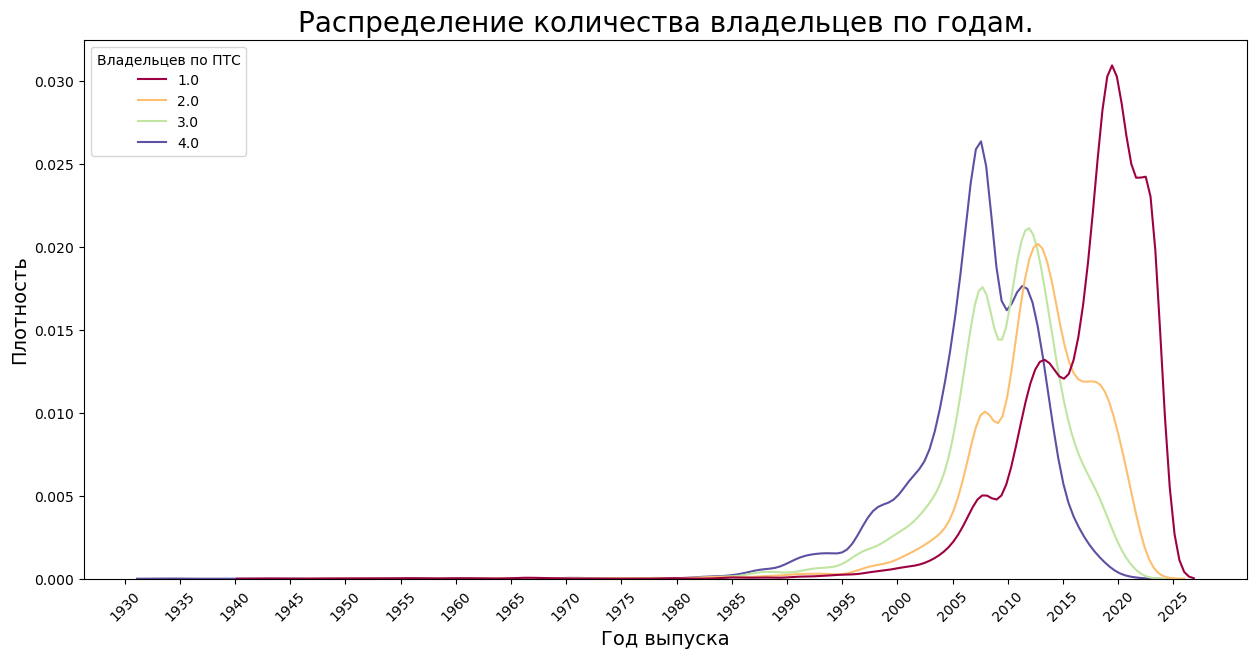

In [24]:
plt.figure(figsize=(15, 7))

sns.kdeplot(data=df,
            x='Год выпуска',
            hue='Владельцев по ПТС',
            palette='Spectral')
plt.title('Распределение количества владельцев по годам.', fontsize=20)
plt.xlabel('Год выпуска', fontsize=14)
plt.ylabel('Плотность', fontsize=14)
plt.xticks(np.arange(1930, 2026, 5), rotation=45);

**Гипотеза подтвердилась.** Начиная с 2013-2014 годов выпуска и старше, достаточно много автомобилей с количеством владельцев 4 или больше. 2-3 владельца имеют автомобили 2000-2022 годов. И явно виден тренд, что чем новее автомобиль, тем больше вероятность, что владелец у него 1.

# Feature Engineering.

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37568 entries, 0 to 37567
Data columns (total 29 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Название авто                    37568 non-null  object 
 1   Рейтинг                          36861 non-null  float64
 2   Цена                             37568 non-null  int64  
 3   Расположение                     37568 non-null  object 
 4   Год выпуска                      37568 non-null  float64
 5   Поколение                        37568 non-null  object 
 6   Пробег, км                       33530 non-null  float64
 7   История пробега, кол-во записей  31357 non-null  float64
 8   Владельцев по ПТС                33530 non-null  float64
 9   Состояние                        37568 non-null  object 
 10  Модификация                      37524 non-null  object 
 11  Объём двигателя, л               37442 non-null  float64
 12  Тип двигателя     

Первым делом разберёмся с пропусками. Для заполнения воспользуемся следующей стратегией: сначала заполним, если это возможно по связанным по смыслу признакам, исправим некорректные значения, затем используем многомерный метод заполнения при помощи IterativeImputer. Это позволит нам более информативно заполнить пропуки и разнообразит наши данные. Также удалим возможные нежелательные символы в именах колонок перед сохранением датафрейма.

In [26]:
df = df.rename(columns = lambda x:re.sub('[^A-Za-zА-яа-я0-9_-ё]+', '_', x))

## Модификация.

Начнём с признака Модификация.

In [27]:
df[~df['Модификация'].isna()][10:20]

,Название_авто,Рейтинг,Цена,Расположение,Год_выпуска,Поколение,Пробег_км,История_пробега_кол_во_записей,Владельцев_по_ПТС,Состояние,Модификация,Объём_двигателя_л,Тип_двигателя,Коробка_передач,Привод,Комплектация,Тип_кузова,Цвет,Руль,Управление_климатом,ПТС,Обмен,Бренд_авто,Модель_авто,Город,Федеральный_округ,Наименование_поколения,Выпуск_кол_во_лет,Мощность_двигателя_лс
10,"Audi Q8 3.0 AT, 2023 Новый",NaN,17450000,"Москва, МКАД, 51-й километр, 10",2023.000,I рестайлинг (2023—2024),NaN,NaN,NaN,Не битый,50 TDI 3.0 quattro Tiptronic,3.000,Дизель,Автомат,Полный,Базовая,Внедорожник 5-дверный,Чёрный,Левый,Климат-контроль многозонный,NaN,NaN,Audi,Q8,Москва,Центральный,I рестайлинг,1.000,286.000
11,"Audi Q5 2.0 AMT, 2011, 218 225 км",4.500,1475000,"Московская обл., Подольск, пр-т Юных Ленинцев, 1И",2011.000,I (2008—2012),218225.000,13.000,3.000,Не битый,2.0 TDI quattro S tronic,2.000,Дизель,Робот,Полный,Базовая,Внедорожник 5-дверный,Серебряный,Левый,Климат-контроль многозонный,NaN,Возможен,Audi,Q5,Подольск,Центральный,I,4.000,170.000
12,"Audi Q2 1.5 AMT, 2021, 2 404 км",NaN,3449000,"Санкт-Петербург, Стартовая ул., 10",2021.000,I рестайлинг (2020—2024),2404.000,5.000,1.000,Не битый,35 TFSI 1.5 S tronic,1.500,Бензин,Робот,Передний,Базовая,Внедорожник 5-дверный,Белый,Левый,Климат-контроль многозонный,NaN,Возможен,Audi,Q2,Санкт-Петербург,Северо-Западный,I рестайлинг,4.000,150.000
13,"Audi Q7 3.0 AT, 2020, 130 000 км",5.000,6990000,"Москва, Каширское ш., 148к3",2020.000,4M рестайлинг (2019—2024),130000.000,0.000,1.000,Не битый,45 TDI 3.0 quattro Tiptronic,3.000,Дизель,Автомат,Полный,NaN,Внедорожник 5-дверный,Белый,Левый,NaN,Электронный,Не интересует,Audi,Q7,Москва,Центральный,4M рестайлинг,5.000,249.000
14,"Audi Q5 Sportback 2.0 AMT, 2022, 50 км",NaN,8349900,"Московская обл., Балашиха, территория Западная...",2022.000,FY (2020—2024),50.000,0.000,1.000,Не битый,40 TDI 2.0 quattro S tronic,2.000,Дизель,Робот,Полный,Базовая,Внедорожник 5-дверный,Чёрный,Левый,Климат-контроль многозонный,NaN,Возможен,Audi,Q5 Sportback,Балашиха,Центральный,FY,4.000,204.000
15,"Audi Q3 2.0 AMT, 2014, 85 958 км",4.800,2158000,"Москва, Михайловский пр., 3с2",2014.000,I (2011—2014),85958.000,5.000,2.000,Не битый,2.0 TFSI quattro S tronic,2.000,Бензин,Робот,Полный,Базовая,Внедорожник 5-дверный,Чёрный,Левый,NaN,NaN,Возможен,Audi,Q3,Михайлов,Центральный,I,3.000,170.000
16,"Audi A5 1.8 CVT, 2013, 137 322 км",4.600,1499000,"Москва, Нововладыкинский пр., 2с1",2013.000,I рестайлинг (2011—2016),137322.000,11.000,2.000,Не битый,1.8 TFSI Multitronic,1.800,Бензин,Вариатор,Передний,NaN,Купе,Серебряный,Левый,Климат-контроль однозонный,NaN,Возможен,Audi,A5,Москва,Центральный,I рестайлинг,5.000,170.000
17,"Audi Q5 2.0 AT, 2014, 114 000 км",4.700,1649000,"Москва, Варшавское ш., 125с1В",2014.000,I рестайлинг (2012—2017),114000.000,16.000,2.000,Не битый,2.0 TFSI quattro Tiptronic,2.000,Бензин,Автомат,Полный,NaN,Внедорожник 5-дверный,Белый,Левый,Климат-контроль многозонный,NaN,Возможен,Audi,Q5,Москва,Центральный,I рестайлинг,5.000,225.000
18,"Audi A3 1.4 AMT, 2013, 145 000 км",4.700,1190000,"Санкт-Петербург, Таллинское ш., 202",2013.000,8V (2012—2016),145000.000,9.000,3.000,Не битый,1.4 TFSI S tronic,1.400,Бензин,Робот,Передний,NaN,Хетчбек 5-дверный,Белый,Левый,Климат-контроль многозонный,NaN,NaN,Audi,A3,Санкт-Петербург,Северо-Западный,8V,4.000,122.000
19,"Audi RS Q8 4.0 AT, 2019, 8 987 км",5.000,15090000,"Московская обл., Балашиха, территория Западная...",2019.000,I (2019—2024),8987.000,2.000,1.000,Не битый,4.0 TFSI quattro Tiptronic,4.000,Бензин,Автомат,Полный,Quattro,Внедорожник 5-дверный,Оранжевый,Левый,Климат-контроль многозонный,NaN,NaN,Audi,RS Q8,Балашиха,Центральный,I,5.000,600.000


Как видим, модификация есть в названии авто, если это не что-то специфичное. Например в строке "Mazda 3 2.5 AT, 2021, 31 000 км	" модификацией будет 2.5 AT.

In [28]:
def modification_fill(mod_str: str) -> str:
    '''Функция для возврата подстроки из заданной строки. '''
    first_split = mod_str.split(',')[0]
    second_split = first_split.split()
    if '.' in first_split:
        return ' '.join(x for x in second_split[-2:])
    else:
        return second_split[-1]       

In [29]:
df.loc[df['Модификация'].isna(), 'Модификация'] = df[
    df['Модификация'].isna()]['Название_авто'].apply(modification_fill)

In [30]:
df[df['Модификация'].isna()]

,Название_авто,Рейтинг,Цена,Расположение,Год_выпуска,Поколение,Пробег_км,История_пробега_кол_во_записей,Владельцев_по_ПТС,Состояние,Модификация,Объём_двигателя_л,Тип_двигателя,Коробка_передач,Привод,Комплектация,Тип_кузова,Цвет,Руль,Управление_климатом,ПТС,Обмен,Бренд_авто,Модель_авто,Город,Федеральный_округ,Наименование_поколения,Выпуск_кол_во_лет,Мощность_двигателя_лс


## Объём двигателя, л.

В этом признаке есть выброс.

In [31]:
df.loc[df['Объём_двигателя_л'] > 7, 'Объём_двигателя_л']

12565   331805.000
Name: Объём_двигателя_л, dtype: float64

Заполним выброс Nan'ом, чтобы затем его обработать.

In [32]:
df.loc[df['Объём_двигателя_л'] > 7, 'Объём_двигателя_л'] = np.NaN
df['Объём_двигателя_л'].max()

6.4

In [33]:
df['Объём_двигателя_л'].isna().sum()

127

## Управление климатом.

In [34]:
mode_list = list(df['Управление_климатом'].value_counts().index[:5])
mode_list

['Климат-контроль многозонный',
 'Кондиционер',
 'Климат-контроль однозонный',
 'Управление на руле',
 'Атермальное остекление']

In [35]:
df['Управление_климатом'].value_counts(dropna=False)

Управление_климатом
NaN                            16679
Климат-контроль многозонный    10791
Кондиционер                     5279
Климат-контроль однозонный      3863
Управление на руле               738
Атермальное остекление           207
Кожа                               3
Цветной                            2
Тёмный                             2
Салон                              2
Шины и диски                       1
Противотуманные                    1
Name: count, dtype: int64

Надо разобраться со странными значениями Кожа, Цветной, Тёмный, Противотуманные, Салон. Управление на руле оставим, пусть оно подразумевает наличие управления климатом, но с расположением на руле.

In [36]:
df.loc[~df['Управление_климатом'].isin(mode_list)
       & ~df['Управление_климатом'].isna(),
       'Управление_климатом'] = 'Климат-контроль многозонный'
df['Управление_климатом'].value_counts(dropna=False)

Управление_климатом
NaN                            16679
Климат-контроль многозонный    10802
Кондиционер                     5279
Климат-контроль однозонный      3863
Управление на руле               738
Атермальное остекление           207
Name: count, dtype: int64

## Работа с пропусками.

In [37]:
df.isna().sum()

Название_авто                         0
Рейтинг                             707
Цена                                  0
Расположение                          0
Год_выпуска                           0
Поколение                             0
Пробег_км                          4038
История_пробега_кол_во_записей     6211
Владельцев_по_ПТС                  4038
Состояние                             0
Модификация                           0
Объём_двигателя_л                   127
Тип_двигателя                         0
Коробка_передач                       0
Привод                                0
Комплектация                       7278
Тип_кузова                          111
Цвет                                  0
Руль                                  0
Управление_климатом               16679
ПТС                               10572
Обмен                              6815
Бренд_авто                            0
Модель_авто                           0
Город                              1401


Поступим следующим образом: категориальные данные заполним самым частотным признаком (модой), а числовые заполним с помощью MICE метода IterativeImputer с регрессором RandomForest, предварительно разбив данные на train/test. Но прежде удалим уже не нужные признаки.

In [38]:
df['Поколение'] = df['Наименование_поколения']
df = df.drop(config['columns_to_drop'], axis=1)

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37568 entries, 0 to 37567
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Рейтинг                         36861 non-null  float64
 1   Цена                            37568 non-null  int64  
 2   Год_выпуска                     37568 non-null  float64
 3   Поколение                       37567 non-null  object 
 4   Пробег_км                       33530 non-null  float64
 5   История_пробега_кол_во_записей  31357 non-null  float64
 6   Владельцев_по_ПТС               33530 non-null  float64
 7   Состояние                       37568 non-null  object 
 8   Модификация                     37568 non-null  object 
 9   Объём_двигателя_л               37441 non-null  float64
 10  Тип_двигателя                   37568 non-null  object 
 11  Коробка_передач                 37568 non-null  object 
 12  Привод                          

Удалим малоинформативные объекты, имеющие всего 1 категорию в признаке Модификация. Их немного, около 1%, так что это не должно повлиять на работу будущей модели.

In [40]:
df = df.loc[~df['Модификация'].isin(df['Модификация'].value_counts()[
    df['Модификация'].value_counts() < 2].index)]

Для сохранения сбалансированности значений признаков, стратифицируем по признаку с наименьшим количеством уникальных значений.

In [41]:
cat_columns = df.select_dtypes('object').columns
num_columns = df.select_dtypes(['int64', 'float64']).columns

strat_column = df[cat_columns].nunique().idxmin()
print(f"Столбец для стратификации: {strat_column}.")

Столбец для стратификации: Состояние.


In [42]:
df_train, df_test = train_test_split(df,
                                     test_size=0.15,
                                     stratify=df[strat_column],
                                     random_state=SEED)

numeric_transformer = Pipeline(
    steps=[('imputer',
            IterativeImputer(estimator=RandomForestRegressor(
                random_state=SEED),
                             max_iter=10,
                             random_state=SEED))])

categorical_transformer = Pipeline(
    steps=[('imputer', SimpleImputer(strategy='most_frequent'))])

preprocessor = ColumnTransformer(
    transformers=[('num', numeric_transformer,
                   num_columns), ('cat', categorical_transformer,
                                  cat_columns)])

df_train = pd.DataFrame(preprocessor.fit_transform(df_train),
                        columns=num_columns.tolist() + cat_columns.tolist())
df_test = pd.DataFrame(preprocessor.transform(df_test),
                       columns=num_columns.tolist() + cat_columns.tolist())
for col in df.columns:
    df_train[col] = df_train[col].astype(df[col].dtype)
    df_test[col] = df_test[col].astype(df[col].dtype)

In [43]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31547 entries, 0 to 31546
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Рейтинг                         31547 non-null  float64
 1   Цена                            31547 non-null  int64  
 2   Год_выпуска                     31547 non-null  float64
 3   Пробег_км                       31547 non-null  float64
 4   История_пробега_кол_во_записей  31547 non-null  float64
 5   Владельцев_по_ПТС               31547 non-null  float64
 6   Объём_двигателя_л               31547 non-null  float64
 7   Выпуск_кол_во_лет               31547 non-null  float64
 8   Мощность_двигателя_лс           31547 non-null  float64
 9   Поколение                       31547 non-null  object 
 10  Состояние                       31547 non-null  object 
 11  Модификация                     31547 non-null  object 
 12  Тип_двигателя                   

In [44]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5568 entries, 0 to 5567
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Рейтинг                         5568 non-null   float64
 1   Цена                            5568 non-null   int64  
 2   Год_выпуска                     5568 non-null   float64
 3   Пробег_км                       5568 non-null   float64
 4   История_пробега_кол_во_записей  5568 non-null   float64
 5   Владельцев_по_ПТС               5568 non-null   float64
 6   Объём_двигателя_л               5568 non-null   float64
 7   Выпуск_кол_во_лет               5568 non-null   float64
 8   Мощность_двигателя_лс           5568 non-null   float64
 9   Поколение                       5568 non-null   object 
 10  Состояние                       5568 non-null   object 
 11  Модификация                     5568 non-null   object 
 12  Тип_двигателя                   55

In [45]:
df_train.describe()

,Рейтинг,Цена,Год_выпуска,Пробег_км,История_пробега_кол_во_записей,Владельцев_по_ПТС,Объём_двигателя_л,Выпуск_кол_во_лет,Мощность_двигателя_лс
count,31547.000,31547.000,31547.000,31547.000,31547.000,31547.000,31547.000,31547.000,31547.000
mean,4.666,1836389.079,2012.991,146856.329,8.667,2.288,2.006,5.055,157.134
std,0.241,2403974.691,7.535,107164.221,7.644,1.183,0.709,3.295,70.867
min,2.800,1000.000,1943.000,1.000,0.000,1.000,0.600,1.000,48.000
25%,4.600,639000.000,2008.000,63222.000,3.000,1.000,1.600,3.000,109.000
50%,4.700,1225000.000,2013.000,146037.000,7.000,2.000,1.800,4.000,143.000
75%,4.800,2280000.000,2019.000,210000.000,12.000,3.000,2.100,6.000,186.000
max,5.000,48000000.000,2024.000,1000000.000,99.000,4.000,6.200,42.000,700.000


In [46]:
df_train.describe(include='object')

,Поколение,Состояние,Модификация,Тип_двигателя,Коробка_передач,Привод,Комплектация,Тип_кузова,Цвет,Руль,Управление_климатом,ПТС,Обмен,Бренд_авто,Модель_авто,Город,Федеральный_округ
count,31547,31547,31547,31547,31547,31547,31547,31547,31547,31547,31547,31547,31547,31547,31547,31547,31547
unique,543,2,1045,5,4,3,849,13,17,2,5,3,2,28,837,637,8
top,I,Не битый,1.6 MT,Бензин,Автомат,Передний,Базовая,Внедорожник 5-дверный,Белый,Левый,Климат-контроль многозонный,Оригинал,Не интересует,Renault,RX,Москва,Центральный
freq,9097,31120,3787,27367,13466,19099,15039,12501,7690,30509,23009,24153,23716,1464,679,4691,11829


In [47]:
df_test.describe()

,Рейтинг,Цена,Год_выпуска,Пробег_км,История_пробега_кол_во_записей,Владельцев_по_ПТС,Объём_двигателя_л,Выпуск_кол_во_лет,Мощность_двигателя_лс
count,5568.000,5568.000,5568.000,5568.000,5568.000,5568.000,5568.000,5568.000,5568.000
mean,4.665,1838547.429,2013.073,148315.389,8.910,2.303,2.002,5.038,157.097
std,0.241,2224793.292,7.471,108072.348,8.155,1.190,0.701,3.397,68.524
min,2.900,10000.000,1934.000,1.000,0.000,1.000,0.700,1.000,50.000
25%,4.600,650000.000,2008.000,62659.000,3.000,1.000,1.600,3.000,109.000
50%,4.700,1249950.000,2013.000,148000.000,7.000,2.000,1.800,4.000,143.000
75%,4.800,2300750.000,2019.000,213000.000,12.000,3.000,2.200,6.000,188.000
max,5.000,34900000.000,2024.000,999999.000,81.000,4.000,6.200,42.000,612.000


In [48]:
df_test.describe(include='object')

,Поколение,Состояние,Модификация,Тип_двигателя,Коробка_передач,Привод,Комплектация,Тип_кузова,Цвет,Руль,Управление_климатом,ПТС,Обмен,Бренд_авто,Модель_авто,Город,Федеральный_округ
count,5568,5568,5568,5568,5568,5568,5568,5568,5568,5568,5568,5568,5568,5568,5568,5568,5568
unique,341,2,647,5,4,3,417,13,17,2,5,3,2,28,519,417,8
top,I,Не битый,1.6 MT,Бензин,Автомат,Передний,Базовая,Внедорожник 5-дверный,Белый,Левый,Климат-контроль многозонный,Оригинал,Не интересует,Renault,Focus,Москва,Центральный
freq,1587,5493,661,4808,2378,3326,2684,2263,1401,5393,4098,4276,4223,267,136,827,2078


## Генерация дополнительных признаков.

Сразу сформируем признак по ПТС - Много владельцев. 4 будет подразумевать 4 и более - значение будет 1, остальные - значение 0.

In [49]:
for dataframe in [df_train, df_test]:
    dataframe['Много_владельцев'] = np.where(
        dataframe['Владельцев_по_ПТС'] == 4, 1, 0)

In [50]:
df_train['Много_владельцев'].value_counts()

Много_владельцев
0    24403
1     7144
Name: count, dtype: int64

Также, думаю, будет полезен признак - Срок эксплуатации.

In [51]:
curr_year = datetime.now().year
for dataframe in [df_train, df_test]:
    dataframe['Срок_эксплуатации'] = curr_year - dataframe[
        'Год_выпуска'].astype('int')
df_train['Срок_эксплуатации'][:5]

0    11
1    10
2    16
3    13
4    10
Name: Срок_эксплуатации, dtype: int32

Ещё попробуем добавить Степень износа автомобиля по пробегу авто - категориальный признак, будут бины до 60 тысяч - малая, 60-100 тысяч - умеренная, 100-180 тысяч - средняя, 180 + большая.

In [52]:
for dataframe in [df_train, df_test]:
    dataframe['Степень_износа'] = pd.cut(
        dataframe['Пробег_км'].astype('int'),
        bins=[0, 60000, 100000, 180000, 1500000],
        labels=['Маленькая', 'Умеренная', 'Средняя', 'Большая'])
df_train['Степень_износа'].value_counts()

Степень_износа
Большая      11295
Средняя       9018
Маленькая     7688
Умеренная     3546
Name: count, dtype: int64

Также бинаризуем признак Обмен.

In [53]:
for dataframe in [df_train, df_test]:
    dataframe['Обмен'] = dataframe['Обмен'].map({
        'Возможен': 1,
        'Не интересует': 0
    })

In [54]:
df_train[:5]

,Рейтинг,Цена,Год_выпуска,Пробег_км,История_пробега_кол_во_записей,Владельцев_по_ПТС,Объём_двигателя_л,Выпуск_кол_во_лет,Мощность_двигателя_лс,Поколение,Состояние,Модификация,Тип_двигателя,Коробка_передач,Привод,Комплектация,Тип_кузова,Цвет,Руль,Управление_климатом,ПТС,Обмен,Бренд_авто,Модель_авто,Город,Федеральный_округ,Много_владельцев,Срок_эксплуатации,Степень_износа
0,4.600,700000,2013.000,20800.000,19.000,4.000,2.000,5.000,135.000,I,Не битый,2.0 4WD MT,Бензин,Механика,Полный,Базовая,Внедорожник 5-дверный,Серебряный,Левый,Климат-контроль многозонный,Оригинал,0,Renault,Duster,Нижневартовск,Уральский,1,11,Маленькая
1,4.900,1300000,2014.000,400000.000,18.000,2.000,2.000,3.000,148.000,XV50,Не битый,2.0 AT,Бензин,Автомат,Передний,Standard,Седан,Белый,Левый,Управление на руле,Оригинал,0,Toyota,Camry,Москва,Центральный,0,10,Большая
2,4.700,749900,2008.000,165000.000,7.000,2.000,1.600,4.000,122.000,ED,Не битый,1.6 MT,Бензин,Механика,Передний,Comfort,Универсал,Чёрный,Левый,Климат-контроль однозонный,Оригинал,0,Kia,Ceed,Екатеринбург,Уральский,0,16,Средняя
3,4.800,610000,2011.000,286000.000,20.000,3.000,1.400,4.000,160.000,Mk6,Не битый,1.4 TSI MT,Бензин,Механика,Передний,Базовая,Хетчбек 5-дверный,Белый,Левый,Управление на руле,Дубликат,1,Volkswagen,Golf,Дмитров,Центральный,0,13,Большая
4,4.800,5000000,2014.000,245000.000,32.000,4.000,4.500,3.000,235.000,200 рестайлинг,Не битый,4.5 D AT,Дизель,Автомат,Полный,Базовая,Внедорожник 5-дверный,Белый,Левый,Климат-контроль многозонный,Оригинал,0,Toyota,Land Cruiser,Екатеринбург,Уральский,1,10,Большая


In [55]:
df_test[:5]

,Рейтинг,Цена,Год_выпуска,Пробег_км,История_пробега_кол_во_записей,Владельцев_по_ПТС,Объём_двигателя_л,Выпуск_кол_во_лет,Мощность_двигателя_лс,Поколение,Состояние,Модификация,Тип_двигателя,Коробка_передач,Привод,Комплектация,Тип_кузова,Цвет,Руль,Управление_климатом,ПТС,Обмен,Бренд_авто,Модель_авто,Город,Федеральный_округ,Много_владельцев,Срок_эксплуатации,Степень_износа
0,4.800,1000000,2009.000,203290.000,9.000,4.000,1.800,3.000,140.000,VIII рестайлинг,Не битый,1.8 AT,Бензин,Автомат,Передний,Executive,Седан,Красный,Левый,Климат-контроль однозонный,Оригинал,0,Honda,Civic,Соликамск,Приволжский,1,15,Большая
1,4.700,799999,2006.000,270000.000,9.000,4.000,2.000,7.000,136.000,I,Не битый,2.0 4WD MT,Бензин,Механика,Полный,Базовая,Внедорожник 5-дверный,Серебряный,Левый,Кондиционер,Оригинал,0,Mitsubishi,Outlander,Москва,Центральный,1,18,Большая
2,4.900,2019000,2023.000,21374.200,2.640,1.000,1.500,4.000,143.000,II,Не битый,1.5 AMT,Бензин,Робот,Передний,Family,Внедорожник 5-дверный,Белый,Левый,Климат-контроль многозонный,Оригинал,1,Haval,M6,Тамбов,Центральный,0,1,Маленькая
3,4.800,745000,2013.000,154235.000,12.000,2.000,1.500,5.000,105.000,II,Не битый,1.5 MT,Бензин,Механика,Передний,LT,Седан,Серебряный,Левый,Климат-контроль многозонный,Оригинал,0,Chevrolet,Cobalt,Тверь,Центральный,0,11,Средняя
4,4.500,2998000,2015.000,155099.000,5.000,3.000,2.000,3.000,238.000,Z10,Не битый,NX 200 2.0t 4WD AT,Бензин,Автомат,Полный,Premium,Внедорожник 5-дверный,Серый,Левый,Климат-контроль однозонный,Оригинал,1,Lexus,NX,Пермь,Приволжский,0,9,Средняя


## Цена - целевая пременная.

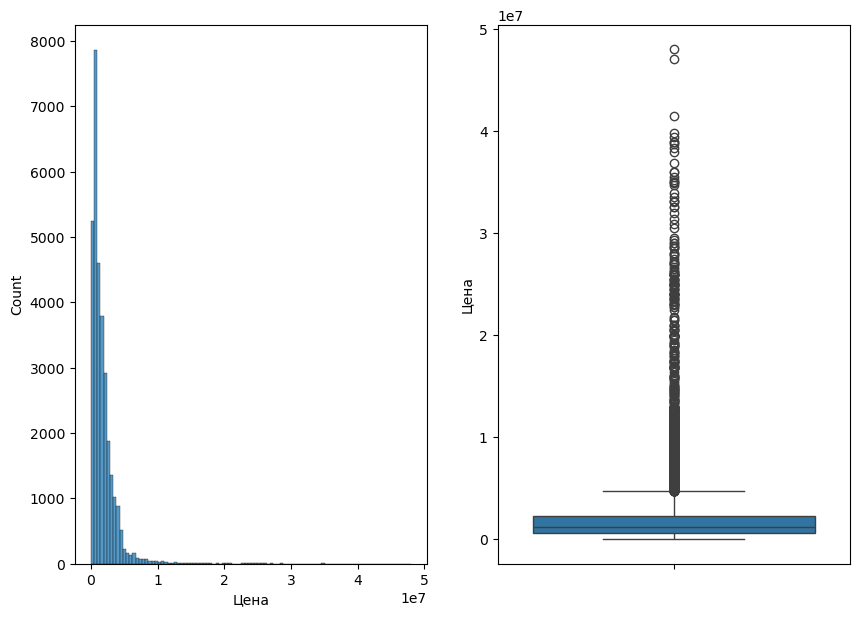

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(10,7))
    
sns.histplot(df_train['Цена'], bins=100, ax=axes[0])
sns.boxplot(df_train['Цена'], ax=axes[1]);

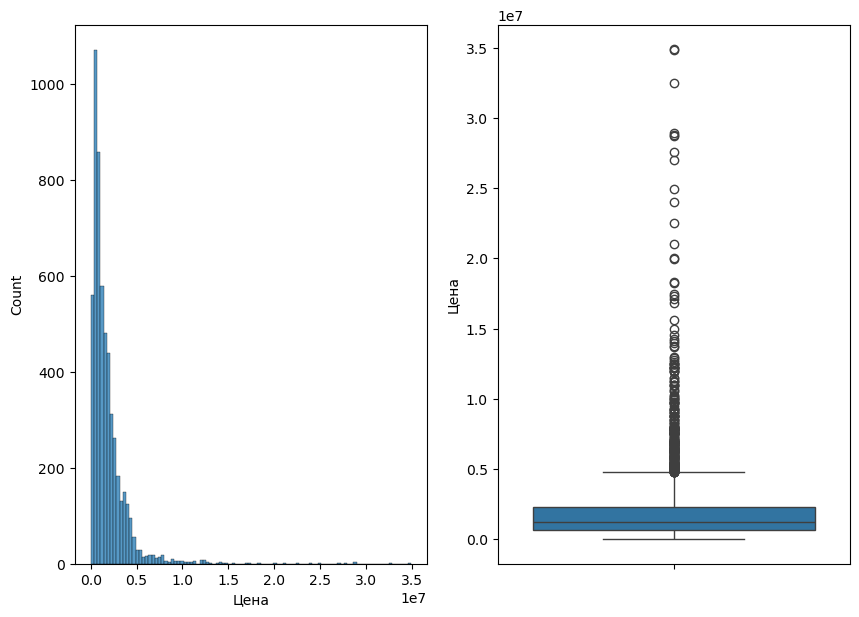

In [57]:
fig, axes = plt.subplots(1, 2, figsize=(10,7))
    
sns.histplot(df_test['Цена'], bins=100, ax=axes[0])
sns.boxplot(df_test['Цена'], ax=axes[1]);

In [58]:
df_train.loc[df_train['Цена'] > 30000000]

,Рейтинг,Цена,Год_выпуска,Пробег_км,История_пробега_кол_во_записей,Владельцев_по_ПТС,Объём_двигателя_л,Выпуск_кол_во_лет,Мощность_двигателя_лс,Поколение,Состояние,Модификация,Тип_двигателя,Коробка_передач,Привод,Комплектация,Тип_кузова,Цвет,Руль,Управление_климатом,ПТС,Обмен,Бренд_авто,Модель_авто,Город,Федеральный_округ,Много_владельцев,Срок_эксплуатации,Степень_износа
46,4.674,36000000,2010.000,2470.000,2.000,1.000,6.200,4.000,571.000,C197,Не битый,SLS AMG 6.2 V8 R-Tronic,Бензин,Робот,Задний,Базовая,Купе,Серый,Левый,Климат-контроль многозонный,Оригинал,0,Mercedes-Benz,SLS-класс AMG,Воскресенск,Центральный,0,14,Маленькая
1047,4.600,38900000,2024.000,10.000,0.520,1.000,4.400,3.000,615.000,V,Не битый,P615 4.4 MHEV AT,Бензин,Автомат,Полный,SV,Внедорожник 5-дверный,Чёрный,Левый,Климат-контроль многозонный,Электронный,1,Land Rover,Range Rover,Москва,Центральный,0,0,Маленькая
1608,4.600,33100000,2023.000,5.800,0.640,1.000,4.400,3.000,530.000,V,Не битый,P530 4.4 AT,Бензин,Автомат,Полный,SV,Внедорожник 5-дверный,Зелёный,Левый,Климат-контроль многозонный,Оригинал,0,Land Rover,Range Rover,Ленинск,Южный,0,1,Маленькая
1748,4.285,35000000,2024.000,1400.200,1.210,1.000,4.400,2.000,635.000,III,Не битый,P635 4.4 AT,Бензин,Автомат,Полный,SV Edition One,Внедорожник 5-дверный,Золотой,Левый,Климат-контроль многозонный,Оригинал,0,Land Rover,Range Rover Sport,Ленинск,Южный,0,0,Маленькая
1977,4.300,47000000,2024.000,1603.550,1.110,1.000,4.400,2.000,635.000,III,Не битый,P635 4.4 AT,Бензин,Автомат,Полный,SV Edition One,Внедорожник 5-дверный,Золотой,Левый,Климат-контроль многозонный,Оригинал,0,Land Rover,Range Rover Sport,Москва,Центральный,0,0,Маленькая
3241,4.600,39400000,2024.000,50.000,0.280,1.000,4.400,3.000,615.000,V,Не битый,P615 4.4 MHEV AT,Бензин,Автомат,Полный,SV,Внедорожник 5-дверный,Чёрный,Левый,Климат-контроль многозонный,Электронный,0,Land Rover,Range Rover,Москва,Центральный,0,0,Маленькая
4647,4.500,33900000,2024.000,1.000,0.687,1.000,4.000,6.000,585.000,W463,Не битый,G 63 AMG 4.0 4MATIC 9G-Tronic,Бензин,Автомат,Полный,AMG G 63,Внедорожник 5-дверный,Серый,Левый,Климат-контроль многозонный,Электронный,1,Mercedes-Benz,G-класс AMG,Москва,Центральный,0,0,Маленькая
6730,4.600,31400000,2022.000,3000.000,0.000,1.000,4.400,3.000,530.000,V,Не битый,P530 4.4 AT,Бензин,Автомат,Полный,Autobiography L (7 мест),Внедорожник 5-дверный,Чёрный,Левый,Климат-контроль многозонный,Оригинал,0,Land Rover,Range Rover,Москва,Центральный,0,2,Маленькая
9832,4.600,32990000,2023.000,1.000,0.688,1.000,4.400,3.000,530.000,V,Не битый,P530 4.4 AT,Бензин,Автомат,Полный,Базовая,Внедорожник 5-дверный,Бежевый,Левый,Климат-контроль многозонный,Оригинал,0,Land Rover,Range Rover,Екатеринбург,Уральский,0,1,Маленькая
11726,4.600,34990000,2024.000,2.000,0.540,1.000,4.400,3.000,615.000,V,Не битый,P615 4.4 MHEV AT,Бензин,Автомат,Полный,SV,Внедорожник 5-дверный,Чёрный,Левый,Климат-контроль многозонный,Электронный,0,Land Rover,Range Rover,Москва,Центральный,0,0,Маленькая


In [59]:
df_test.loc[df_test['Цена'] > 30000000]

,Рейтинг,Цена,Год_выпуска,Пробег_км,История_пробега_кол_во_записей,Владельцев_по_ПТС,Объём_двигателя_л,Выпуск_кол_во_лет,Мощность_двигателя_лс,Поколение,Состояние,Модификация,Тип_двигателя,Коробка_передач,Привод,Комплектация,Тип_кузова,Цвет,Руль,Управление_климатом,ПТС,Обмен,Бренд_авто,Модель_авто,Город,Федеральный_округ,Много_владельцев,Срок_эксплуатации,Степень_износа
1037,4.600,34900000,2022.000,10.000,3.000,1.000,4.400,3.000,530.000,V,Не битый,P530 4.4 AT,Бензин,Автомат,Полный,SV,Внедорожник 5-дверный,Синий,Левый,Климат-контроль многозонный,Оригинал,1,Land Rover,Range Rover,Москва,Центральный,0,2,Маленькая
1689,4.570,32486757,2023.000,28.970,0.850,1.000,4.000,3.000,585.000,R232,Не битый,SL 63 AMG 4.0 AT,Бензин,Автомат,Полный,Особая Серия,Кабриолет,Серый,Левый,Климат-контроль многозонный,Оригинал,0,Mercedes-Benz,SL-класс AMG,Приморск,Северо-Западный,0,1,Маленькая
4803,4.600,34850000,2023.000,11.000,0.000,1.000,4.400,3.000,530.000,V,Не битый,P530 4.4 AT,Бензин,Автомат,Полный,Базовая,Внедорожник 5-дверный,Чёрный,Левый,Климат-контроль многозонный,Оригинал,0,Land Rover,Range Rover,Москва,Центральный,0,1,Маленькая


Так как целевая переменная распределена не нормально, очень похоже на геометрическое распределение, при обучении линейных моделей будем её логарифмировать. Разброс цен достаточно большой - многие обычные автомобили стоят в пределах 2-3 миллионов, в то время как элитные авто достигают 48 миллионов!

In [60]:
df_train.to_csv('./data_store/train.csv', index=False)
df_test.to_csv('./data_store/test.csv', index=False)